# Lab 4 Confidence Intervals of Fits

## Table of Contents
1. **[Errors of Fits](#errors_of_fits)**  
    1.1 **[Confidence Intervals with TGraphs](#CI_TG)**  
    1.2 **[Confidence Intervals with TH1F and TH1D](#CI_TH1D)**  
    1.3 **[Exercise](#exercise)**

## 1. Errors of Fits <a name="errors_of_fits" />

### 1.1 Confidence Intervals with TGraphs <a name="CI_TG" />
When assessing the uncertainty of a fit, we can not simply use the error of the parameters to compute a 'band of error'. Each parameter is coorelated and their errors as a result are also coorelated. Therefore, we must use statistical analyses to compute these error bands at a certain confidence interval. To illustrate this concept, we will be using the ``TF1`` and ``TVirtualFitter`` classes from ``ROOT``.
First, we will start with the simplest example: fit a line to datapoints generated from a linear function smeared with a gaussian. 

In [1]:
import ROOT
from ROOT import TGraph, gRandom, TCanvas, TGraphErrors, TVirtualFitter
import numpy as np

Welcome to JupyROOT 6.17/01


In [2]:
#generate linear datapoints smeared with a gaussian
m = 2 #slope of the line
b = 0 #y-intercept of the line
ngr = 100 #number of datapoints
gr = TGraph(ngr)

for i in range(ngr):
    x = gRandom.Uniform(0,1) #randomly pick a value between 0 and 1
    y = b + m*x + gRandom.Gaus(0,0.4) #evaluate function at x smear with a gaussian of mean 0, and sigma 0.4
    gr.SetPoint(i,x,y) #add the point to the TGraph
    

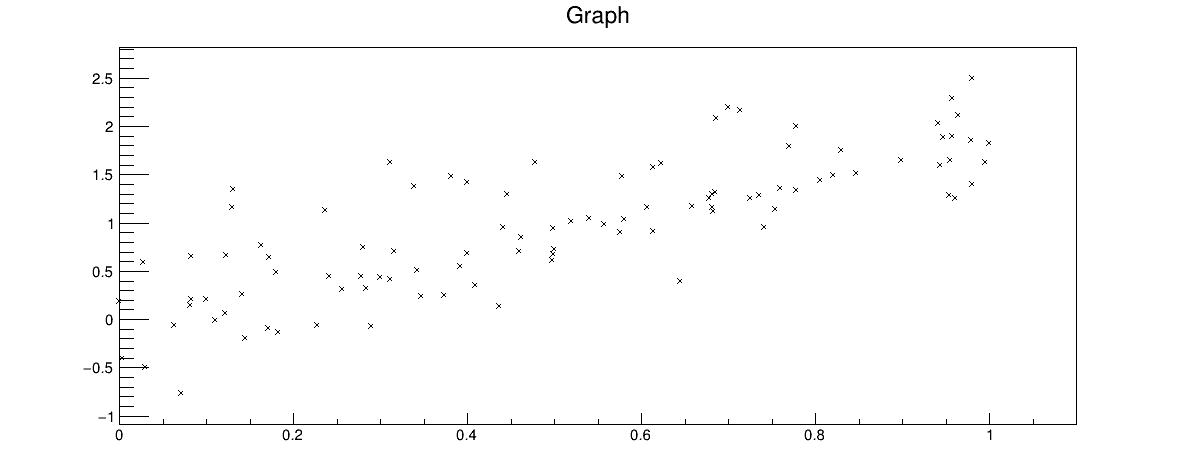

In [3]:
#Draw the TGraph 'gr'
canvas = TCanvas("canvas_1", "Confidence intervals of the fitted function", 1200, 500)
gr.SetName("Graph Smeared w/ Gaussian")
gr.SetMarkerStyle(5)
gr.SetMarkerSize(0.7)
gr.Draw("AP")
canvas.Draw()

Now lets fit a line to these datapoints. Recall how the ``TF1`` class is constructed from Lab 2. Since we generated these datapoints, we know what the values of the final fit should be. We will set the initial values of our parameters to the values of the function we generated the points from.

In [4]:
#Create Fit Function
fitting_function = ROOT.TF1("linear", "[0]*x + [1]", 0, 1)
fitting_function.SetParameter(0, 2)
fitting_function.SetParameter(1, 0)

#Fit fitting function with TGraph
fitting_function.SetLineWidth(2)
gr.Fit(fitting_function, "S")


****************************************
Minimizer is Minuit / Migrad
Chi2                      =      17.0125
NDf                       =           98
Edm                       =  4.32681e-22
NCalls                    =           32
p0                        =       1.8667   +/-   0.140361    
p1                        =    0.0363716   +/-   0.0817599   


Once the function is fit to the datapoints of the TGraph, we can use ``TVirtualFitter`` and ``TGraphErrors`` to create a graph that holds the confidence intervals. We will compute the $95\%$ confidence interval of our fit, or the band where we are $95\%$ sure the fit lies within.

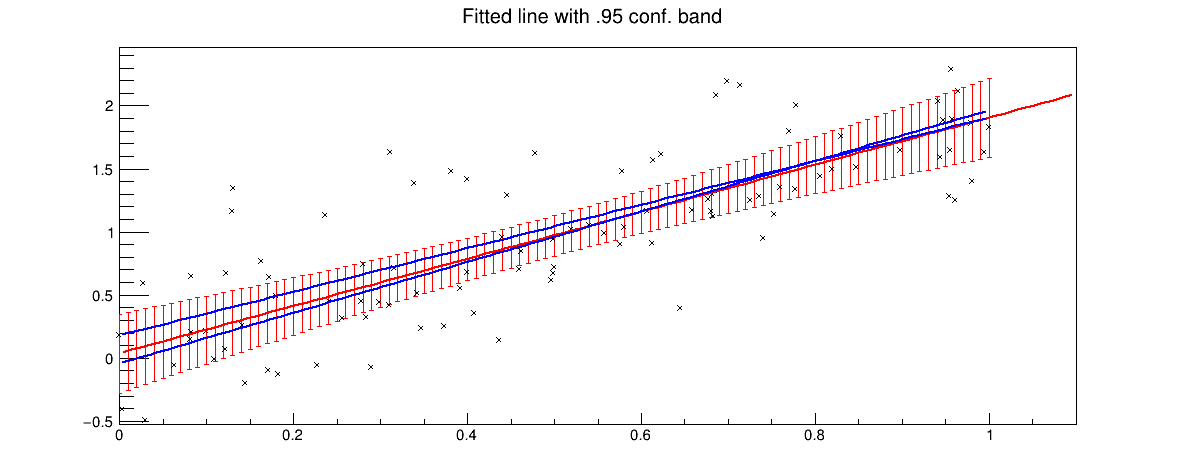

In [10]:
grint = TGraphErrors(ngr)
grint.SetTitle("Fitted line with .95 conf. band")
x_values = np.arange(0.0, 1.01, (1.0-0.0)/ngr)
for i in range(len(x_values)):
    grint.SetPoint(i, x_values[i], 0)
    ##Compute CI at x points
    TVirtualFitter.GetFitter().GetConfidenceIntervals(grint, 0.95)
    ##Now 'grint' graph contains function values as y-coordinates
    ##and confident intervals as the errors on these coordinates
    ##Draw the graph, the function, and the confidence intervals

##Create naive fit error lines
#plus/minus configuration
function_error_1 = ROOT.TF1("line error 1", "[0]*x + [1]", 0, 1)
function_error_1.SetParameter(0, fitting_function.GetParameter(0) + fitting_function.GetParError(0))
function_error_1.SetParameter(1, fitting_function.GetParameter(1) - fitting_function.GetParError(1))
function_error_1.SetLineColor(ROOT.kBlue)
#minus/plus configuration
function_error_2 = ROOT.TF1("line error 2", "[0]*x + [1]", 0, 1)
function_error_2.SetParameter(0, fitting_function.GetParameter(0) - fitting_function.GetParError(0))
function_error_2.SetParameter(1, fitting_function.GetParameter(1) + fitting_function.GetParError(0))
function_error_2.SetLineColor(ROOT.kBlue)


grint.SetLineColor(ROOT.kRed)
grint.Draw("ap")
gr.SetMarkerStyle(5)
gr.SetMarkerSize(0.7)
gr.Draw("psame")
function_error_1.Draw("same")
function_error_2.Draw("same")
canvas.Draw()

Now, along with our fit, we have plotted the band of $95\%$ confidence. As you can see, the band is much larger than naively taking the error of the fit from the fit parameter errors. This is because the errors of the fit parameters are coorelated making the problem not so simple. Now we will see this idea in the context of histograms which is more applicable in the field of HEP.

### 1.2 Confidence Intervals with TH1F and TH1D <a name="CI_TH1D" />
Let's begin by filling a histogram from a gaussian distribution.

In [ ]:
canvas_2 = TCanvas("canvas_2", "Confidence intervals of the fitted function", 1200, 500)

#Create Hist
hist = ROOT.TH1F("h", "Fitted Gaussian with a .95 conf. band", 100, -3, 3) #Create histogram with 100 bins from -3 to 3
nh = 5000 #5000 events
hist.FillRandom("gaus", nh)

Now that we've filled the histogram from a random gaussian, lets create the fitting function. Since we filled it from a gaussian, we will fit it with the pre-defined ``TF1`` gaussian.

In [ ]:
fgaus = ROOT.TF1("fgaus", "gaus", -3, 3)
fgaus.SetLineWidth(2)
hist.Fit(fgaus)
hist.Draw()
canvas_2.Draw()

Now that we have filled the histogram and fitted it with a gaussian, let us now compute the $95\%$ confidence interval band. This is done very similarly to the way with TGraphs.The only difference is that we don't have to iterate through where to draw the confidence interval. 

In [11]:
#Create Hist to hold confidence intervals
hint = ROOT.TH1D('hint', "Fitted gaussian with a .95 conf. band", 100, -3, 3)
TVirtualFitter.GetFitter().GetConfidenceIntervals(hint)
#Now the 'hint' histogram has the fitted function values
#as the bin contents and the CI as bin errors
hint.SetStats(ROOT.kFALSE)
fFillColor = ROOT.TColor.GetColorTransparent(ROOT.kRed, 0.2)
hint.SetFillColor(fFillColor)
#Must Draw in this order since we want the axis range to be determined from hist
#since using an transparent fill color, hist must be drawn on-top of hint
hist.Draw()
hint.Draw("e3same")
canvas_2.Draw()

NameError: name 'hist' is not defined

### 1.3 Exercise <a name="exercise" />

Generate a random scatterplot of 200 points from a line of slope $5$, and y-intercept of $-2$ smeared with a gaussian of mean $0$, and sigma $1$ over $x=(-5,5)$. Then fit a line to this scatterplot and plot the $90\%$ confidence interval band.

In [ ]:
canvas_3 = TCanvas("canvas_2", "Confidence intervals of the fitted function", 1200, 500)
canvas_3.divide(2,1)
canvas_3.cd(1)

#Generate scatterplot

#Create TGraph

#Create Fitting Function

#Fit fitting function with TGraph

#Create TGraphErrors and get CI at 90% confidence

#Draw the TGraph, Function, and confidence intervals


Generate a histogram with 100 bins from 0 to 5, and randomly fill it with 10000 entries from $f(x) = e^{-5x}$. Then fit this histogram with an exponential and find the $80\%$ confidence interval band.

In [ ]:
canvas_3.cd(2)

#Create histogram and fill from a falling exponential

#Create fitting function and fit to histogram

#Create histogram holding confidence intervals

#Draw histogram, fitted function, and 80% CI band

#draw canvas_3
canvas_3.Draw()